In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn.metrics as metrics
import torch
import torchinfo
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

#for data preprocessing
from sklearn.decomposition import PCA

from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                            recall_score, f1_score, classification_report,roc_auc_score, mean_squared_error, roc_curve,
                            auc, matthews_corrcoef,r2_score)
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input
#for modeling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

#filter warnings
import warnings
warnings.filterwarnings("ignore")

import os
#print(os.listdir(r'C:\Users\AMJAD\AD\Datasets')

# Any results you write to the current directory are saved as output.

### Exploratory Data Analysis

In [2]:
df = pd.read_csv(r'C:\Users\AMJAD\AD\Paper 2 - Anomaly Detection In Multivariate Time Series Data Using Deep Ensemble Models\Datasets/creditcard - Copy (2).csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


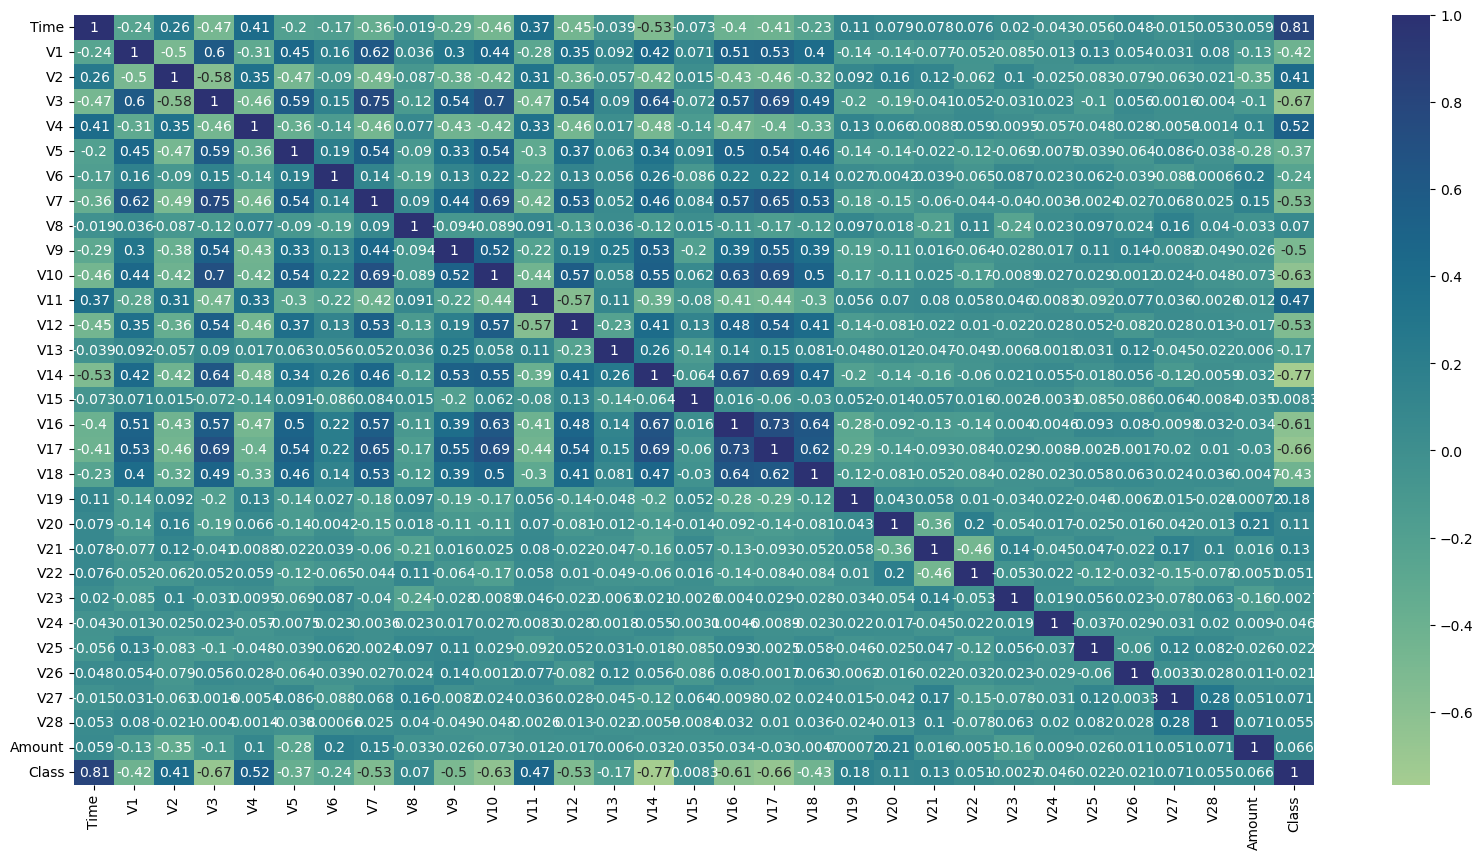

In [3]:
paper = plt.figure(figsize=[20,10])
sns.heatmap(df.corr(),cmap='crest',annot=True)
plt.show()

<Axes: >

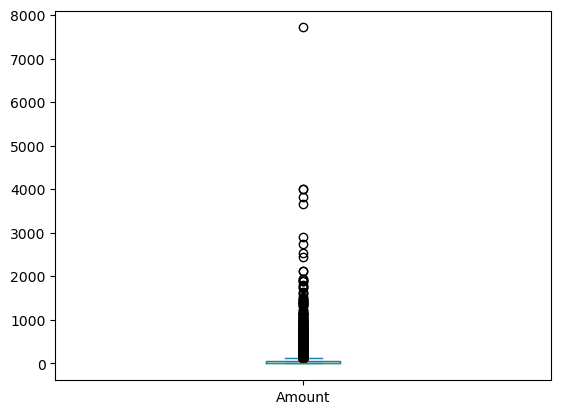

In [4]:
df['Amount'].plot.box()

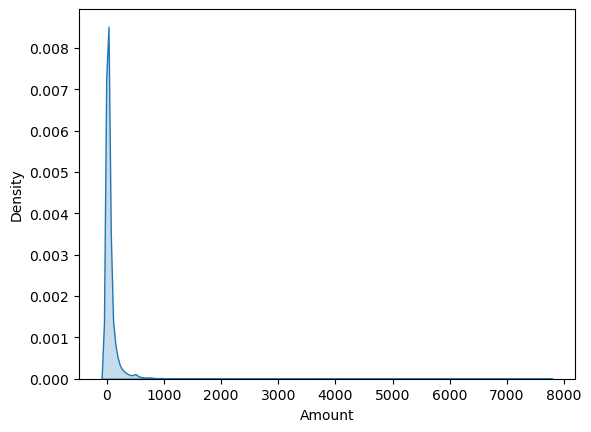

In [5]:
sns.kdeplot(data=df['Amount'], shade=True)
plt.show()

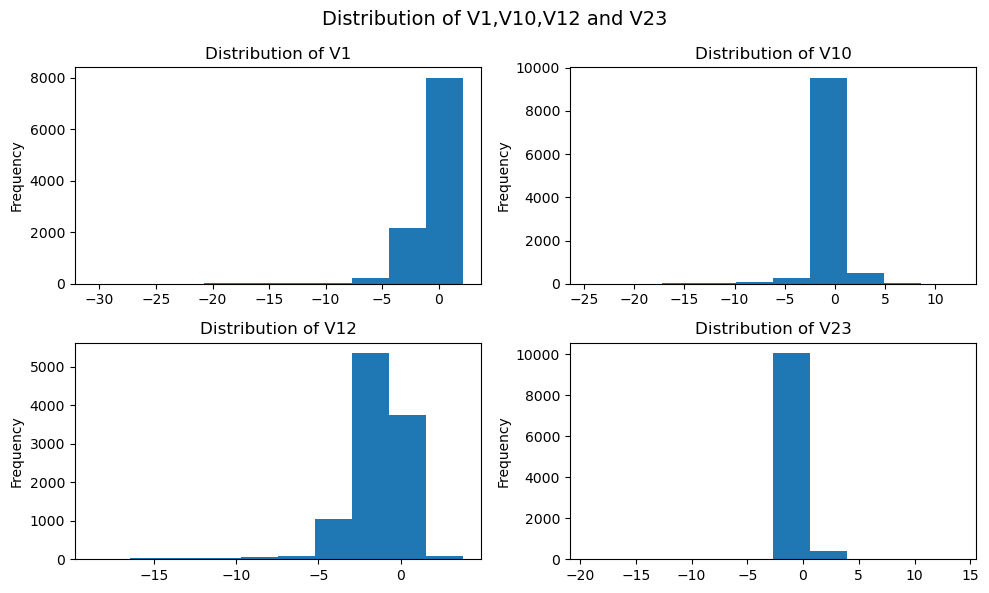

In [6]:
# Lets plot a histogram
paper, axes = plt.subplots(2, 2, figsize=(10, 6))
df['V1'].plot(kind='hist', ax=axes[0,0], title='Distribution of V1')
df['V10'].plot(kind='hist', ax=axes[0,1], title='Distribution of V10')
df['V12'].plot(kind='hist', ax=axes[1,0], title='Distribution of V12')
df['V23'].plot(kind='hist', ax=axes[1,1], title='Distribution of V23')
plt.suptitle('Distribution of V1,V10,V12 and V23',size=14)
plt.tight_layout()
plt.show()

Lets visualize how many fraud cases we have in this dataset

Only `Time` and `Amount` have not been transformed with PCA. Time contains the seconds elapsed between each transaction and the first transaction in the dataset. Lets transofrm this feature into hours to get a better understanding.

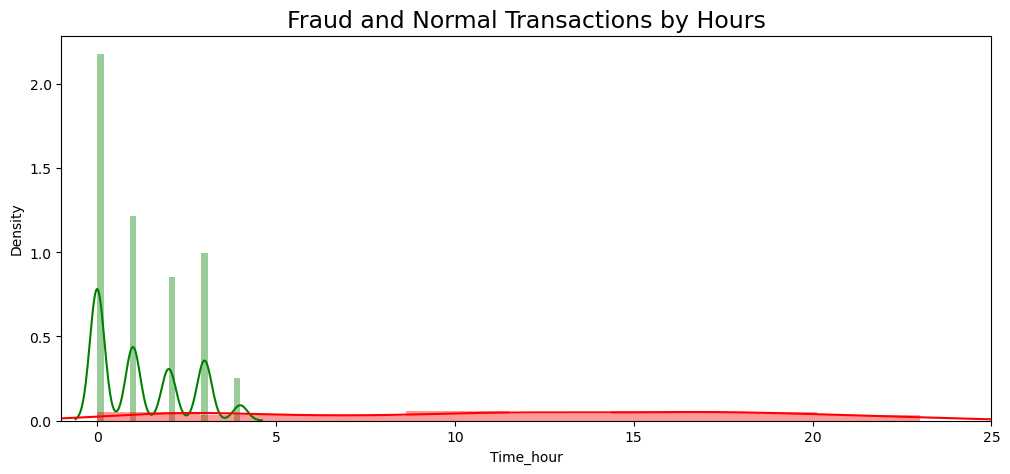

In [7]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], color='g')
sns.distplot(df[df['Class'] == 1]["Time_hour"], color='r')
plt.title('Fraud and Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

Seems like hour of day have some impact on number or fraud cases. Lets move to transform the remaining features.

### Feature Transformation

Lets transform the remaining features using PCA.

In [8]:
cols= df[['Time', 'Amount']]

pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)

df['V29']=X_PCA[:,0]
df['V30']=X_PCA[:,1]

#df.drop(['Time','Time_hour', 'Amount'], axis=1, inplace=True)

df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Time_hour', 'V29', 'V30'],
      dtype='object')

Now lets have a view at distribution of features

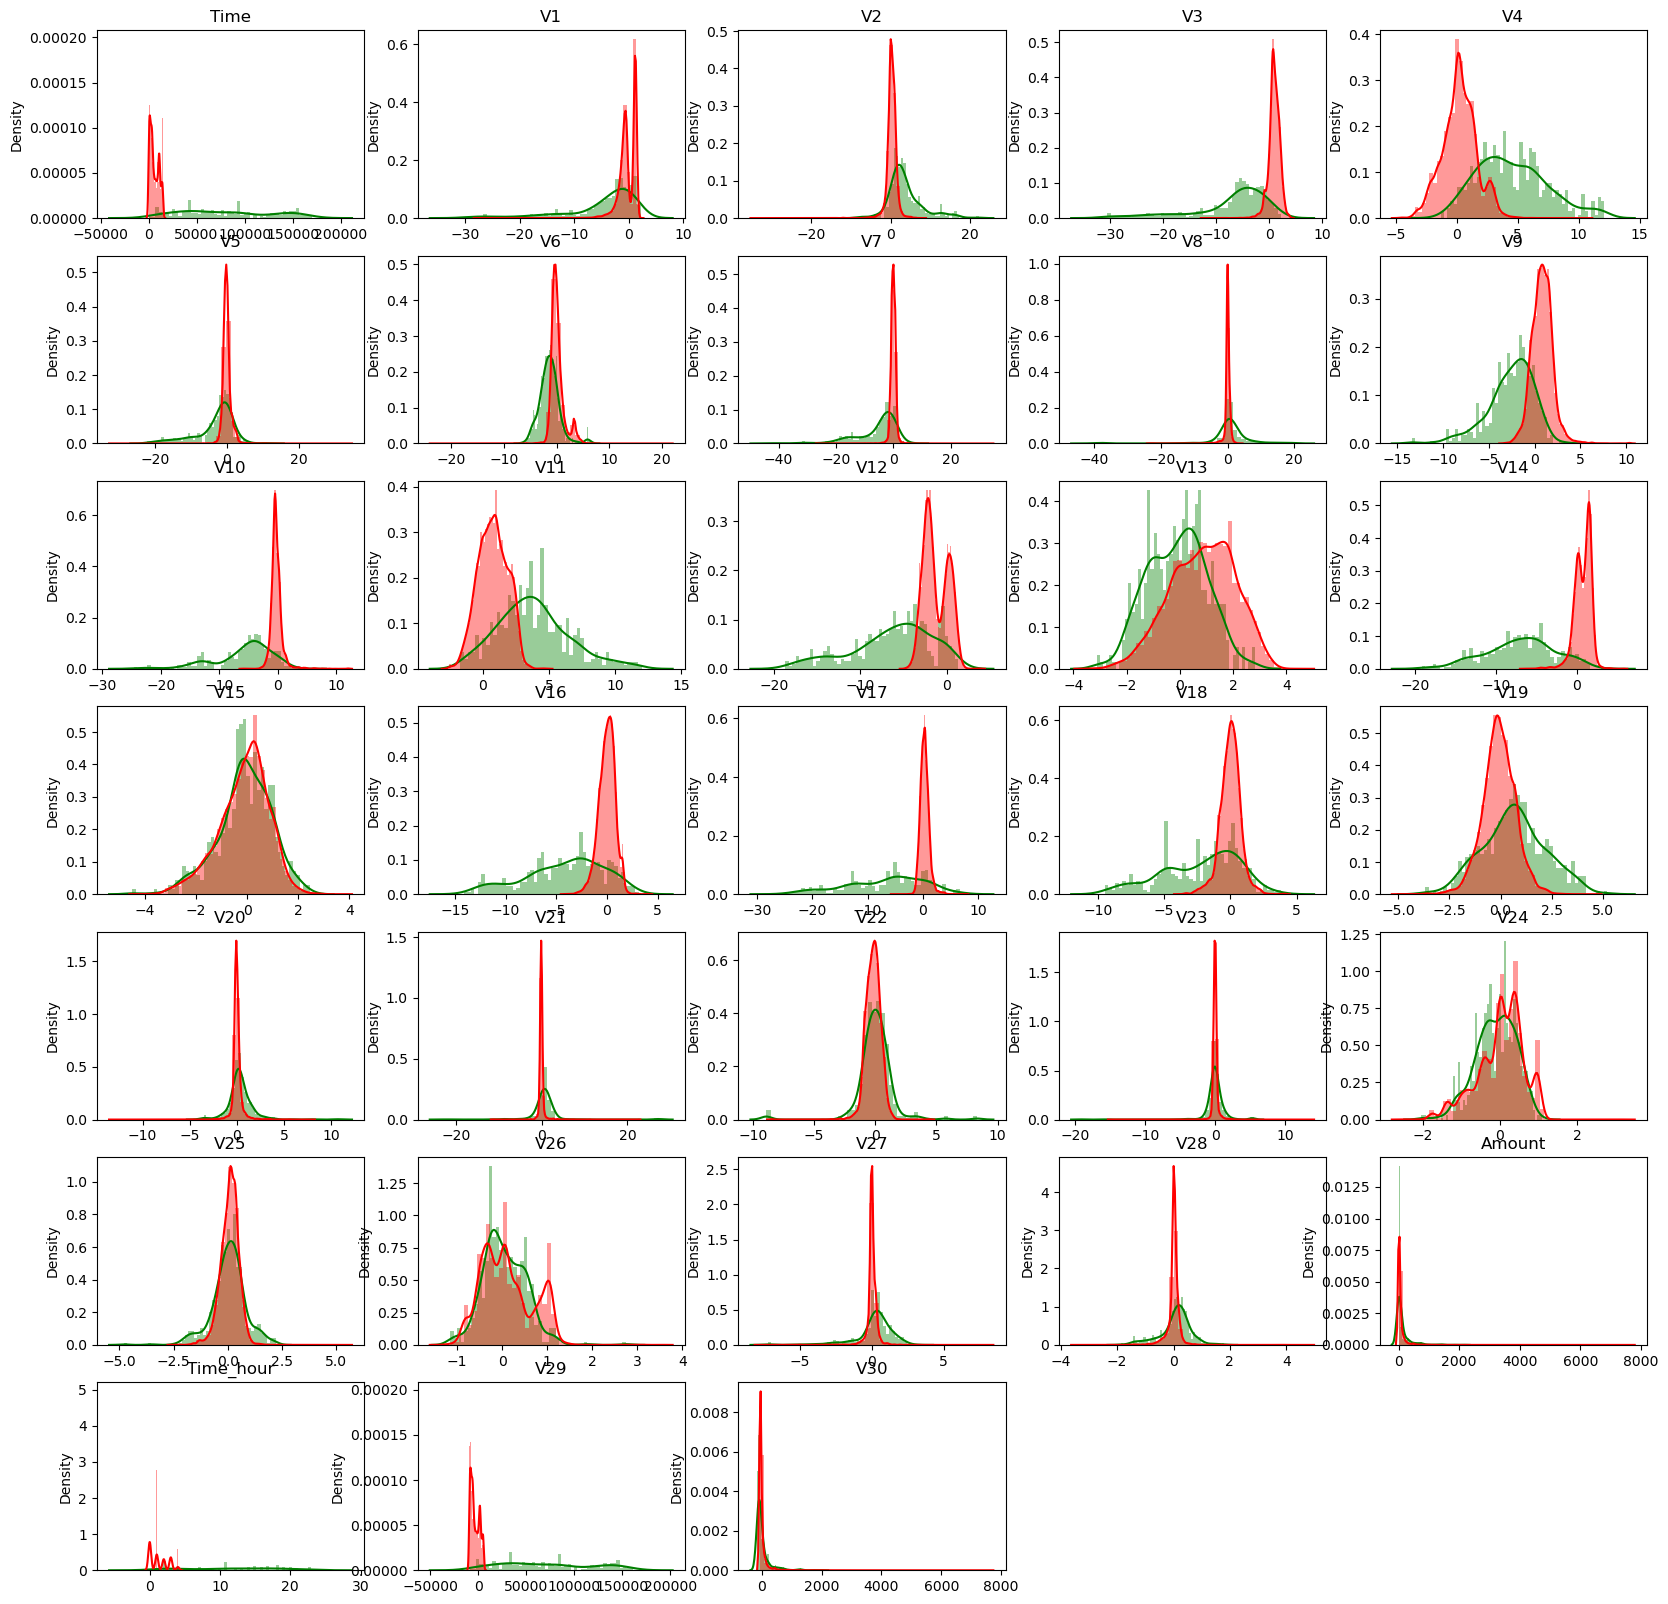

In [9]:
columns = df.drop('Class', axis=1).columns
grid = gridspec.GridSpec(7, 5)

plt.figure(figsize=(20,10*2))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[df.Class==1][col], bins = 50, color='g')
    sns.distplot(df[df.Class==0][col], bins = 50, color='r') 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

In [10]:
X = df.drop("Class", axis=1)
y = df["Class"]
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:



from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)





In [12]:

# Define a more complex DAGMM architecture
class ComplexDAGMM(nn.Module):
    def __init__(self, input_size, encoding_dim, num_gmm_components):
        super(ComplexDAGMM, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),  # Experiment with larger dimensions
            nn.Tanh(),
            nn.Linear(256, 128),  # Experiment with larger dimensions
            nn.Tanh(),
            nn.Linear(128, encoding_dim),  # Experiment with larger dimensions
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),  # Reverse the order in the decoder
            nn.Tanh(),
            nn.Linear(128, 256),  # Reverse the order in the decoder
            nn.Tanh(),
            nn.Linear(256, input_size),  # Reverse the order in the decoder
        )
        self.estimation = nn.Sequential(
            nn.Linear(encoding_dim, num_gmm_components),
        )
        self.bn = nn.BatchNorm1d(encoding_dim, affine=False)

    def forward(self, x):
        x = self.encoder(x)
        z_c = self.bn(x)
        x_hat = self.decoder(x)
        gamma = self.estimation(z_c)
        return x_hat, z_c, gamma


In [13]:
# Hyperparameter tuning
best_params = None
best_score = 0

# Define your dataset and labels

# Split the data into training, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now you have X_train, X_val, X_test, y_train, y_val, y_test correctly defined



In [14]:
# Define the hyperparameter grid
param_grid = {
    'encoding_dim': [8, 16, 32],
    'learning_rate': [1e-5, 1e-6, 1e-7],
    'num_gmm_components': [3, 4, 5]
}

best_params = None
best_score = 0

for params in ParameterGrid(param_grid):
    # Train a DAGMM model with the current hyperparameters
    model = ComplexDAGMM(X_train.shape[1], params['encoding_dim'], params['num_gmm_components'])
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    # Training loop on the training set

    # Evaluation on the validation set
    x_hat_val, z_c_val, gamma_val = model(torch.Tensor(X_val))
    reconstruction_error_val = torch.sum((x_hat_val - torch.Tensor(X_val)) ** 2, dim=1).detach().numpy()
    
    # Calculate ROC AUC score or other chosen evaluation metric
    roc_auc = roc_auc_score(y_val, reconstruction_error_val)

    if roc_auc > best_score:
        best_score = roc_auc
        best_params = params

# Train the final model with the best hyperparameters on the combined training and validation sets
# Evaluate the final model on the test set
# Record and analyze the results

print("Best Hyperparameters:", best_params)



Best Hyperparameters: {'encoding_dim': 16, 'learning_rate': 1e-06, 'num_gmm_components': 5}


In [15]:

# Train the model with the best hyperparameters
best_model = ComplexDAGMM(X_train.shape[1], best_params['encoding_dim'], best_params['num_gmm_components'])
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.MSELoss()
num_epochs = 100
batch_size = 64

# Training loop
for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        best_optimizer.zero_grad()
        x_hat, z_c, gamma = best_model(torch.Tensor(batch))
        loss = criterion(x_hat, torch.Tensor(batch)) + 0.1 * torch.norm(gamma, p=2)
        loss.backward()
        best_optimizer.step()

# Evaluate the best model
x_hat, z_c, gamma = best_model(torch.Tensor(X_test))
reconstruction_error = torch.sum((x_hat - torch.Tensor(X_test)) ** 2, dim=1).detach().numpy()



In [16]:
# Print summary for the ComplexDAGMM model
model = ComplexDAGMM(X_train.shape[1], best_params['encoding_dim'], best_params['num_gmm_components'])
model.eval()
model_info = torchinfo.summary(model, (X_train.shape[0], X_train.shape[1]))
print(model_info)

# Print summary for the best_model
best_model.eval()
best_model_info = torchinfo.summary(best_model, (X_train.shape[0], X_train.shape[1]))
print(best_model_info)

Layer (type:depth-idx)                   Output Shape              Param #
ComplexDAGMM                             [6295, 33]                --
├─Sequential: 1-1                        [6295, 16]                --
│    └─Linear: 2-1                       [6295, 256]               8,704
│    └─Tanh: 2-2                         [6295, 256]               --
│    └─Linear: 2-3                       [6295, 128]               32,896
│    └─Tanh: 2-4                         [6295, 128]               --
│    └─Linear: 2-5                       [6295, 16]                2,064
│    └─Tanh: 2-6                         [6295, 16]                --
├─BatchNorm1d: 1-2                       [6295, 16]                --
├─Sequential: 1-3                        [6295, 33]                --
│    └─Linear: 2-7                       [6295, 128]               2,176
│    └─Tanh: 2-8                         [6295, 128]               --
│    └─Linear: 2-9                       [6295, 256]               33,02

In [17]:

# Determine the threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)

# Classify anomalies
predictions = (reconstruction_error > threshold).astype(int)



In [18]:
# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
fpr, tpr, _ = roc_curve(y_test, predictions)
pr_auc = auc(fpr, tpr)
mcc = matthews_corrcoef(y_test, predictions)
r2 = r2_score(y_test, predictions)



In [19]:
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("PR AUC Score:", pr_auc)
print("Matthews Correlation Coefficient:", mcc)
print("R-squared (R2) Score:", r2)
print("Anomaly Detection Rate:", np.sum(predictions) / len(predictions))
print("False Positive Rate:", fpr[1])
classification = classification_report(y_test, predictions.astype(int))
print("Classification Report:")
print(classification)

Confusion Matrix:
 [[1965   29]
 [  29   76]]
Accuracy: 0.9723677941877085
Precision: 0.7238095238095238
Recall: 0.7238095238095238
F1 Score: 0.7238095238095238
ROC AUC Score: 0.8546329464584228
PR AUC Score: 0.8546329464584228
Matthews Correlation Coefficient: 0.7092658929168458
R-squared (R2) Score: 0.41853178583369166
Anomaly Detection Rate: 0.050023820867079564
False Positive Rate: 0.014543630892678034
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1994
           1       0.72      0.72      0.72       105

    accuracy                           0.97      2099
   macro avg       0.85      0.85      0.85      2099
weighted avg       0.97      0.97      0.97      2099



<Axes: >

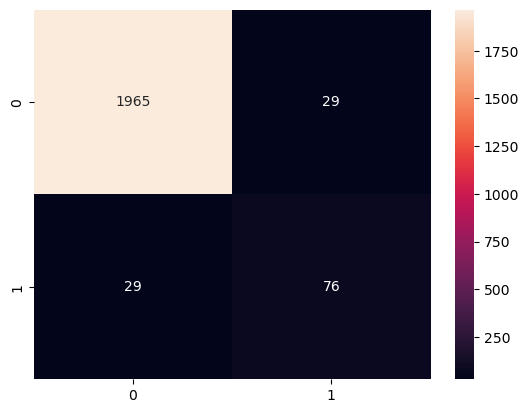

In [20]:

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d')